In [35]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

steps modified for a unified mask rank for all subjects:
    load accuracy for all the ROIs for all subjects
    for each ROI, average the performance from each subject and get a single number for each ROI
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''
subject = "0111171"
N = 15

try:
    roiloc = "wang2014"
    print("Using user-selected roi location: {}".format(roiloc))
except:
    print("NO ROI LOCATION ENTERED: Using roi location of wang2014")
    roiloc = "wang2014"

try:
    dataSource = "neurosketch"  # could be neurosketch or realtime
    print("Using {} data".format(dataSource))
except:
    print("NO DATASOURCE ENTERED: Using original neurosketch data")
    dataSource = 'neurosketch'

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"
    
starttime = time.time()
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = "./{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = "./{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        print(topN[-1])



/gpfs/milgram/pi/turk-browne/projects/rtTest
Using user-selected roi location: wang2014
Using neurosketch data
Running subject 0111171, with neurosketch as a data source, wang2014, starting with 15 ROIs
RESULT_all.shape=(25, 25, 2)
RESULT_all.shape=(25, 2)
8 1
roi9_rh.nii.gz
15 1
roi16_rh.nii.gz
13 0
roi14_lh.nii.gz
1 1
roi2_rh.nii.gz
11 1
roi12_rh.nii.gz
4 1
roi5_rh.nii.gz
9 1
roi10_rh.nii.gz
10 0
roi11_lh.nii.gz
3 0
roi4_lh.nii.gz
12 1
roi13_rh.nii.gz
24 0
roi25_lh.nii.gz
6 0
roi7_lh.nii.gz
7 0
roi8_lh.nii.gz
15 0
roi16_lh.nii.gz
16 0
roi17_lh.nii.gz


In [17]:
import matplotlib.pyplot as plt
# plt.plot(RESULT)
# RESULTix = RESULT[:].argsort()[-N:]
# RESULTix
a=RESULT[:]
a.argsort()


array([ 75, 101, 152, 241, 139, 199,  56,  93, 229, 198, 284,  40, 107,
       156,  68, 248, 143, 244, 131, 128,  33, 136,  19, 161,  31,  63,
       264, 118,  16,  69, 111, 227,   4, 283, 157, 165, 150,  21, 228,
       186, 202,  35, 197, 263, 126, 180,  73,  32,  82, 151,  94,  92,
       114,  99,  42, 171, 240,  51,   5, 201,  41, 145, 294, 173, 271,
        72, 188,  29, 100, 169, 133, 153,  48, 142, 146, 122,   8,  55,
       258, 249, 230, 205, 130, 106,   0, 149,  49,  54, 138, 183, 231,
       226,  84, 290, 287, 127,  66, 125, 124,  20, 105, 255, 192, 273,
         3,  96,  81,  67, 147,  28, 115, 285, 177, 158, 232, 237, 243,
        44, 113, 116, 254, 207, 200, 259, 196, 193, 286,  58,  87, 178,
       174, 184, 176,  95, 213, 194,   6, 217, 225, 140,  13, 206, 233,
       187, 167, 250, 163, 265, 162, 262, 276,  10, 299, 119, 117, 121,
        98, 132, 123,  65,  53, 102,  76, 281, 235, 282, 266,  27, 135,
         2, 108, 189,  47, 268,  11,  71, 212, 251, 179, 221, 17

In [40]:
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
for sub in subjects_correctly_aligned:
    print(sub,end=' ')

1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172 

In [38]:
len(subjects_correctly_aligned)

25

In [39]:
a="1206161 0119173 1206162 1201161 0115174 1130161 1206163 0120171 0111171 1202161 1121161 0125172 0110172 0123173 0120172 0113171 0115172 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0119171 0117171 0119174 0112173 0112174 0125171 0112172"
a=a.split(" ")
len(a)

34

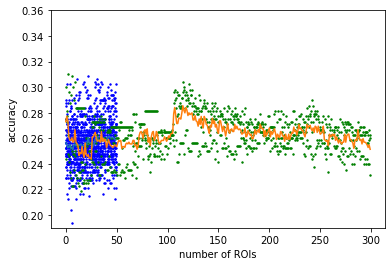

In [6]:
# code to load and compare the result of above:
# SummaryAccuracy.py
from glob import glob
import numpy as np

testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subjects_correctly_aligned
subs=subjects_correctly_aligned
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,3))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt

plt.plot(np.nanmean(wangAcc,axis=1))
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.plot(np.nanmean(schaeferAcc,axis=1))
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.ylim([0.19,0.36])
plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
# plt.savefig('SummaryAccuracy.png')
# next step is to use averageAggregatee.sh to cnvert things to standard space and add things together to visualize things.


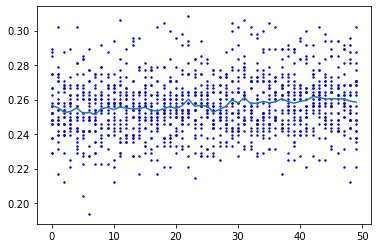

In [43]:
plt.plot(np.nanmean(wangAcc,axis=1))
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)


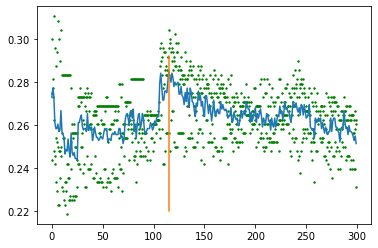

In [49]:
plt.plot(np.nanmean(schaeferAcc,axis=1))
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot([115]*10,np.arange(0.22,0.30,(0.3-0.22)/10))

In [84]:
def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
from glob import glob
import matplotlib.pyplot as plt
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/"
roiloc="schaefer2018"
dataSource="neurosketch"
subjects=glob(workingDir+"/wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
GreedyBestAcc=np.zeros((len(subjects),40))
for ii,subject in enumerate(subjects):            
    for len_topN_1 in range(40,0,-1):
#         Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}.pkl")
        try:
            di = load_obj(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
plt.scatter(GreedyBestAcc,c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")

TypeError: scatter() missing 1 required positional argument: 'y'

In [103]:
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")

import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import sys,pickle
import numpy as np
from sklearn.linear_model import LogisticRegression

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        print(f"run={run}")
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


tmpFile = "./tmp/0112171_116_schaefer2018_neurosketch_116_105"
[_runs,bcvar] = load_obj(tmpFile)
sl_result = Class(_runs, bcvar)

# np.save(tmpFile+'_result',sl_result)

print(f"sl_result={sl_result}")



conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
(6, 80, 49898)
run=0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


run=1


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


run=2


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


run=3


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


run=4


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


run=5
sl_result=0.2354166666666667


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
bcvar

[[['chair',
   'bench',
   'table',
   'bed',
   'chair',
   'table',
   'bench',
   'bed',
   'chair',
   'bench',
   'bed',
   'table',
   'chair',
   'table',
   'bed',
   'bench',
   'bed',
   'chair',
   'table',
   'bench',
   'chair',
   'table',
   'bench',
   'bed',
   'bed',
   'bench',
   'table',
   'chair',
   'chair',
   'bed',
   'table',
   'bench',
   'table',
   'bench',
   'chair',
   'bed',
   'bench',
   'bed',
   'chair',
   'table',
   'table',
   'bed',
   'chair',
   'bench',
   'bed',
   'table',
   'bench',
   'chair',
   'bed',
   'chair',
   'bench',
   'table',
   'bed',
   'table',
   'bench',
   'chair',
   'bed',
   'chair',
   'bench',
   'table',
   'chair',
   'table',
   'bench',
   'bed',
   'bench',
   'bed',
   'chair',
   'table',
   'bed',
   'table',
   'chair',
   'bench',
   'bed',
   'bench',
   'chair',
   'table',
   'bench',
   'table',
   'bed',
   'chair'],
  ['chair',
   'table',
   'bed',
   'bench',
   'chair',
   'bed',
   'table',

In [59]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
# from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''
subject = "1202161" # "0111171"
N = 116

try:
    roiloc = "schaefer2018"
    print("Using user-selected roi location: {}".format(roiloc))
except:
    print("NO ROI LOCATION ENTERED: Using roi location of wang2014")
    roiloc = "wang2014"

try:
    dataSource = "neurosketch"
    print("Using {} data".format(dataSource))
except:
    print("NO DATASOURCE ENTERED: Using original neurosketch data")
    dataSource = 'neurosketch'

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"


workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        # print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        # print(topN[-1])

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    X = X - X.mean(3)
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

def getMask(topN):
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN)

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []

for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    # features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    features = features - featmean
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()


# Preset the variables
print("Runs shape", runs.shape)
bcvar = [metas]
                 
# # Distribute the information to the searchlights (preparing it to run)
# _runs = [runs[:,:,mask==1]]
# print("Runs shape", _runs[0].shape)
# slstart = time.time()
# sl_result = Class(_runs, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))
# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print("waiting\n")
    return np.load(tmpFile+'_result.npy')

# ./tmp/0125171_40_schaefer2018_neurosketch_39.pkl
if os.path.exists(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
    print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_1.pkl exists")
    raise Exception('runned or running')

# N-1
def next(topN):
    print(f"len(topN)={len(topN)}")
    print(f"topN={topN}")

    if len(topN)==1:
        return None
    else:
        try:
            allpairs = itertools.combinations(topN,len(topN)-1)
            topNs=[]
            sl_results=[]
            tmpFiles=[]
            for i,_topN in enumerate(allpairs):
                topNs.append(_topN)
                _mask=getMask(_topN)
                # np.save(tmpFile,_mask)
                _runs = [runs[:,:,_mask==1]]

                print('mask dimensions: {}'. format(_mask.shape))
                print('number of voxels in mask: {}'.format(np.sum(_mask)))
                print("Runs shape", _runs[0].shape)

                tmpFile=f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
                print(f"tmpFile={tmpFile}")
                
                save_obj([_runs,bcvar], tmpFile)
                tmpFiles.append(tmpFile)
                if not os.path.exists(tmpFile+'_result.npy'):
                    subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
                    numberOfJobsRunning = int(open("squeue.txt", "r").read())
                    while numberOfJobsRunning > 100:
                        time.sleep(30)
                        print("waiting 30")
                        subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
                        numberOfJobsRunning = int(open("squeue.txt", "r").read())
                    # get the evidence for the current mask
                    print(f'sbatch class.sh {tmpFile}')
                    proc = subprocess.Popen([f'sbatch class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar) 
                else:
                    print(tmpFile+'_result.npy exists!')

            sl_results=[]
            for tmpFile in tmpFiles:
                sl_result=wait(tmpFile)
                sl_results.append(sl_result)
            print(f"sl_results={sl_results}")
            print(f"max(sl_results)=={max(sl_results)}")
            maxID=np.where(sl_results==max(sl_results))[0][0]
            save_obj({"subject":subject,
            "startFromN":N,
            "currNumberOfROI":len(topN)-1,
            "bestAcc":max(sl_results),
            "bestROIs":topNs[maxID]},
            f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
            )
            print(f"bestAcc={max(sl_results)} For {len(topN)-1} = ./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
            tmpFiles=next(topNs[maxID])
        except:
            return tmpFiles

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
Using user-selected roi location: schaefer2018
Using neurosketch data
Running subject 1202161, with neurosketch as a data source, schaefer2018, starting with 116 ROIs
RESULT.shape=(300,)
len(topN)=116
topN=['284.nii.gz', '226.nii.gz', '230.nii.gz', '59.nii.gz', '296.nii.gz', '204.nii.gz', '19.nii.gz', '68.nii.gz', '197.nii.gz', '25.nii.gz', '30.nii.gz', '253.nii.gz', '89.nii.gz', '185.nii.gz', '179.nii.gz', '36.nii.gz', '241.nii.gz', '34.nii.gz', '239.nii.gz', '291.nii.gz', '134.nii.gz', '124.nii.gz', '87.nii.gz', '240.nii.gz', '15.nii.gz', '189.nii.gz', '97.nii.gz', '193.nii.gz', '268.nii.gz', '31.nii.gz', '208.nii.gz', '106.nii.gz', '149.nii.gz', '199.nii.gz', '121.nii.gz', '298.nii.gz', '116.nii.gz', '1.nii.gz', '142.nii.gz', '299.nii.gz', '139.nii.gz', '183.nii.gz', '281.nii.gz', '14.nii.gz', '111.nii.gz', '21.nii.gz', '74.nii.gz', '178.nii.gz', '71.nii.gz', '18.nii.gz', '198.nii.gz', '257.nii.gz', '75.nii.gz', '

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:185: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 0
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
Runs shape (6, 80, 94, 94, 72)


In [61]:
runs.shape

(6, 80, 94, 94, 72)

In [64]:
print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

if len(topN)==1:
    pass
else:
#     try:
    allpairs = itertools.combinations(topN,len(topN)-1)
    topNs=[]
    sl_results=[]
    tmpFiles=[]
    for i,_topN in enumerate(allpairs):
        topNs.append(_topN)
        _mask=getMask(_topN)
        # np.save(tmpFile,_mask)
        _runs = [runs[:,:,_mask==1]]

        print('mask dimensions: {}'. format(_mask.shape))
        print('number of voxels in mask: {}'.format(np.sum(_mask)))
        print("Runs shape", _runs[0].shape)

len(topN)=116
topN=['284.nii.gz', '226.nii.gz', '230.nii.gz', '59.nii.gz', '296.nii.gz', '204.nii.gz', '19.nii.gz', '68.nii.gz', '197.nii.gz', '25.nii.gz', '30.nii.gz', '253.nii.gz', '89.nii.gz', '185.nii.gz', '179.nii.gz', '36.nii.gz', '241.nii.gz', '34.nii.gz', '239.nii.gz', '291.nii.gz', '134.nii.gz', '124.nii.gz', '87.nii.gz', '240.nii.gz', '15.nii.gz', '189.nii.gz', '97.nii.gz', '193.nii.gz', '268.nii.gz', '31.nii.gz', '208.nii.gz', '106.nii.gz', '149.nii.gz', '199.nii.gz', '121.nii.gz', '298.nii.gz', '116.nii.gz', '1.nii.gz', '142.nii.gz', '299.nii.gz', '139.nii.gz', '183.nii.gz', '281.nii.gz', '14.nii.gz', '111.nii.gz', '21.nii.gz', '74.nii.gz', '178.nii.gz', '71.nii.gz', '18.nii.gz', '198.nii.gz', '257.nii.gz', '75.nii.gz', '227.nii.gz', '132.nii.gz', '145.nii.gz', '153.nii.gz', '293.nii.gz', '280.nii.gz', '275.nii.gz', '214.nii.gz', '154.nii.gz', '236.nii.gz', '190.nii.gz', '93.nii.gz', '271.nii.gz', '209.nii.gz', '113.nii.gz', '143.nii.gz', '182.nii.gz', '235.nii.gz', '10.nii

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:185: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)
mask dimensions: (94, 94, 72)
number of voxels in mask: 0
Runs shape (6, 80, 0)


KeyboardInterrupt: 

In [69]:
_mask=getMask(_topN)
np.sum(_mask)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:185: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


0

In [79]:
topN=_topN
subject="1202161" #"0120172"
for pn, parc in enumerate(topN):
    _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    mask[mask>0] = 1


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [80]:
np.sum(mask)

31476

In [77]:
workingDir+"/{}/{}/{}".format(roiloc, subject, parc)

'/gpfs/milgram/project/turk-browne/projects/rtTest//schaefer2018/0120172/28.nii.gz'

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


(0.19, 0.36)

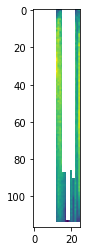

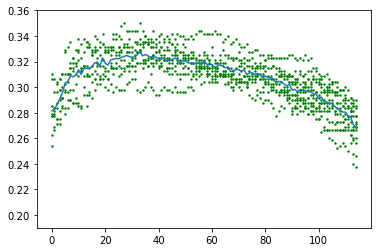

In [1]:
# # plt.savefig('SummaryAccuracy.png')
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

roiloc="schaefer2018"
dataSource="neurosketch"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=116
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,40]=np.load("./{}/{}/output/top{}.npy".format(roiloc, subject, N))
    except:
        pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T

plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


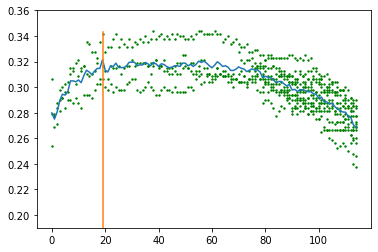

In [49]:
a=np.nanmean(GreedyBestAcc,axis=1)
bestID=np.where(a==np.nanmax(a))[0][0]

_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
plt.ylim([0.19,0.36])


plt.plot([bestID]*10,np.arange(0.19,0.36,(0.36-0.19)/10))

In [27]:
bestID
bestROIss=[]
for subject in subjects:
    try:
        di = load_obj(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{bestID+1}")
        # GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        bestROIs=di['bestROIs']
        bestROIs = [int(bestROI.split(".nii.gz")[0]) for bestROI in bestROIs]
        print(bestROIs)
        bestROIss.append(bestROIs)
    except:
        pass

[284, 226, 204, 19, 253, 134, 124, 15, 31, 139, 14, 18, 198, 153, 214, 209, 272, 61, 276, 213]
[59, 204, 19, 253, 241, 34, 291, 124, 97, 193, 208, 116, 178, 257, 227, 293, 154, 190, 182, 150]
[226, 204, 19, 34, 239, 240, 116, 281, 178, 71, 227, 214, 93, 235, 169, 174, 276, 17, 123, 78]


In [32]:
bestROIss=np.asarray(bestROIss)
len(np.unique(bestROIss))

47

In [39]:
# the brighter means the ROI was used in multiple subjects

# Load the top38 for the subjects_correctly_aligned.
import nibabel as nib
import pandas as pd
# ROIs=[]
# for sub in subjects_correctly_aligned:
#     try:
#         data=pd.read_csv(f"schaefer2018/{sub}/output/top38.csv")
#         ROIs=ROIs+list(data['0'])[:-1]
#     except:
#         Pass

bestROIss=bestROIss.reshape(-1)
sub ="1201161"
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
for pn, parc in enumerate(bestROIss):
    _mask = nib.load(workingDir+"/{}/{}/{}.nii.gz".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
#     mask[mask>0] = 1

savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./top{bestID+1}mask.nii.gz")


# fslview_deprecated ./top20mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1201161/neurosketch_recognition_run_1_bet.nii.gz


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [90]:
len(a['bestROIs'])

114

In [112]:
from subprocess import call
call('squeue -u kp578 | wc -l > squeue.txt',shell=True)
numberOfJobsRunning = int(open("squeue.txt", "r").read())
numberOfJobsRunning

79

In [115]:
a=str(time.time())
type(a)

str

In [116]:
np.save("./tmp/holdon",1)

In [119]:
!ls ./tmp/holdon.npy

./tmp/holdon.npy


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


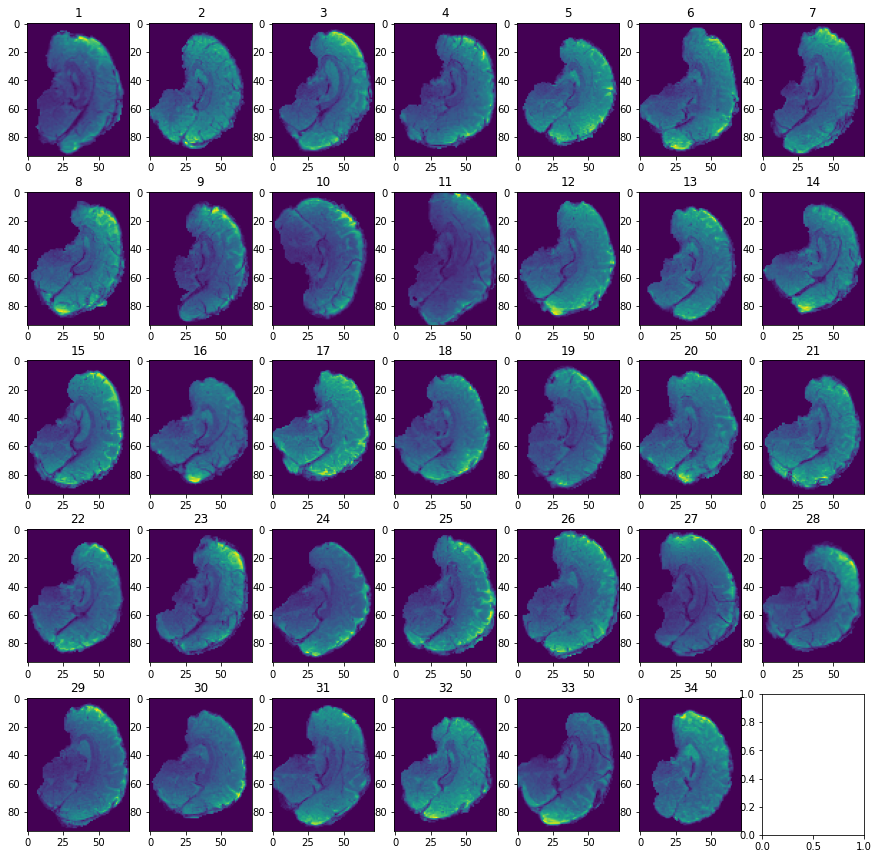

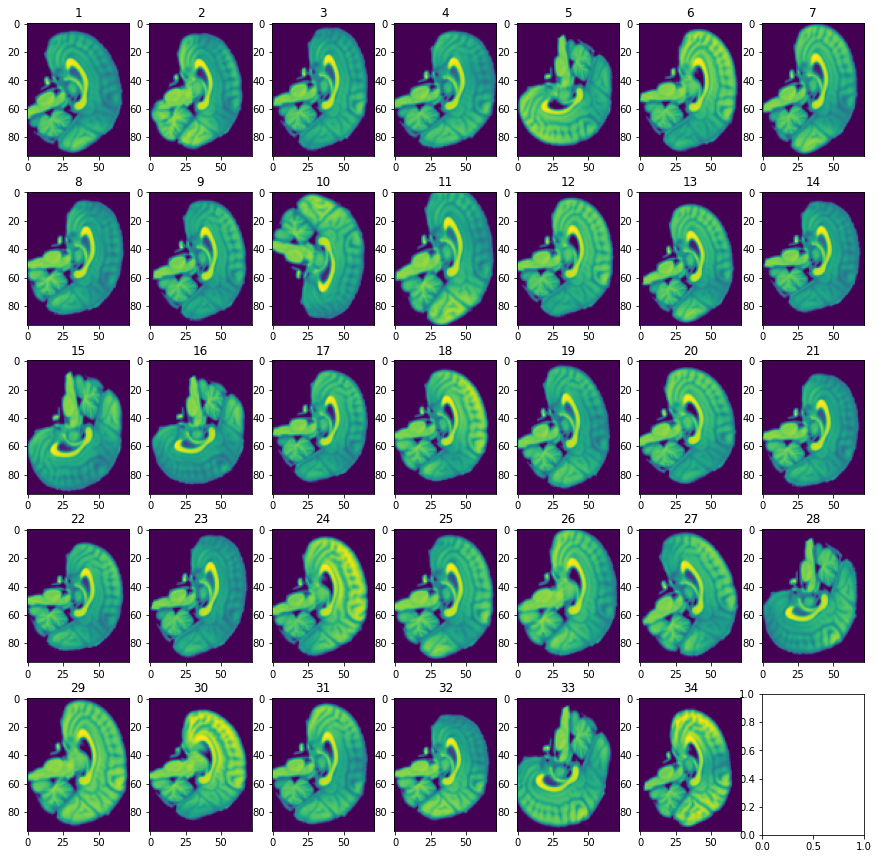

In [3]:
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=subs
    
import nibabel as nib
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"
    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"
    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    template_bet=nib.load(TEMPLATE_bet).get_data()
    axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)




# Part2
import nibabel as nib
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"
    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"
    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    wanginfunc=nib.load(WANGINFUNC).get_data()
    axs[ii].imshow(wanginfunc[int(wanginfunc.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)




In [12]:
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=subs

notAligned=''
correctly_aligned=''
notAligned_subjects=[]
subjects_correctly_aligned=[] #['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
for ii,sub in enumerate(subjects):
    if (ii+1) in [5,15,16,28,33]:
        notAligned=notAligned+sub+' '
        notAligned_subjects.append(sub)
    else:
        correctly_aligned=correctly_aligned+sub+' '
        subjects_correctly_aligned.append(sub)
print(notAligned)

0115174 0120172 0113171 0119171 0125171 


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


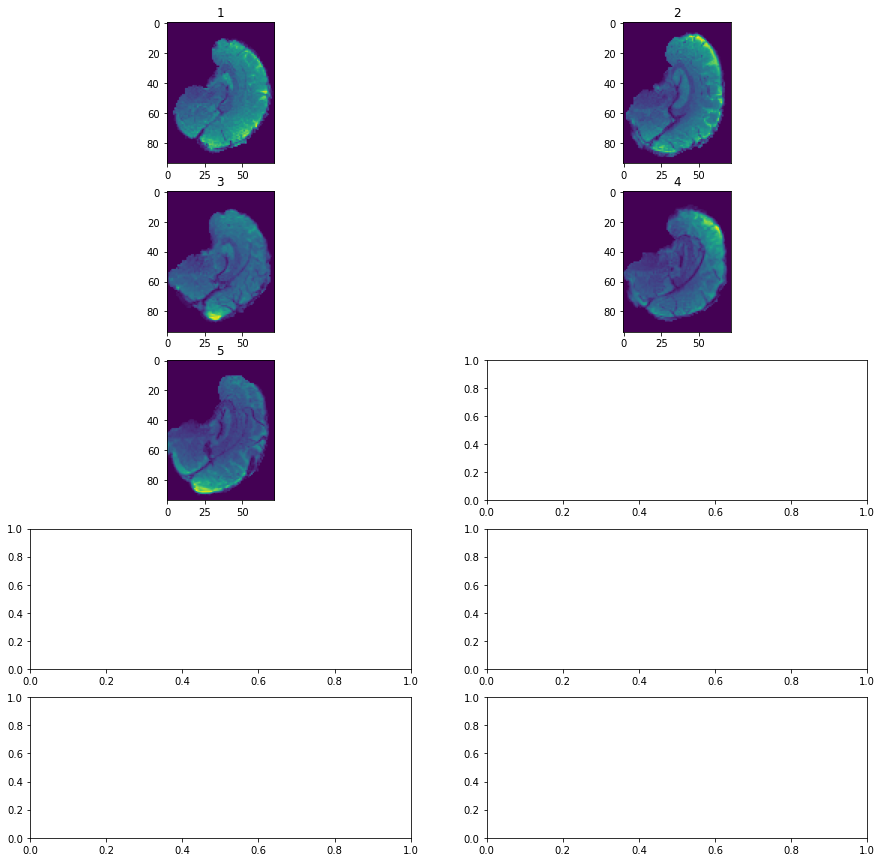

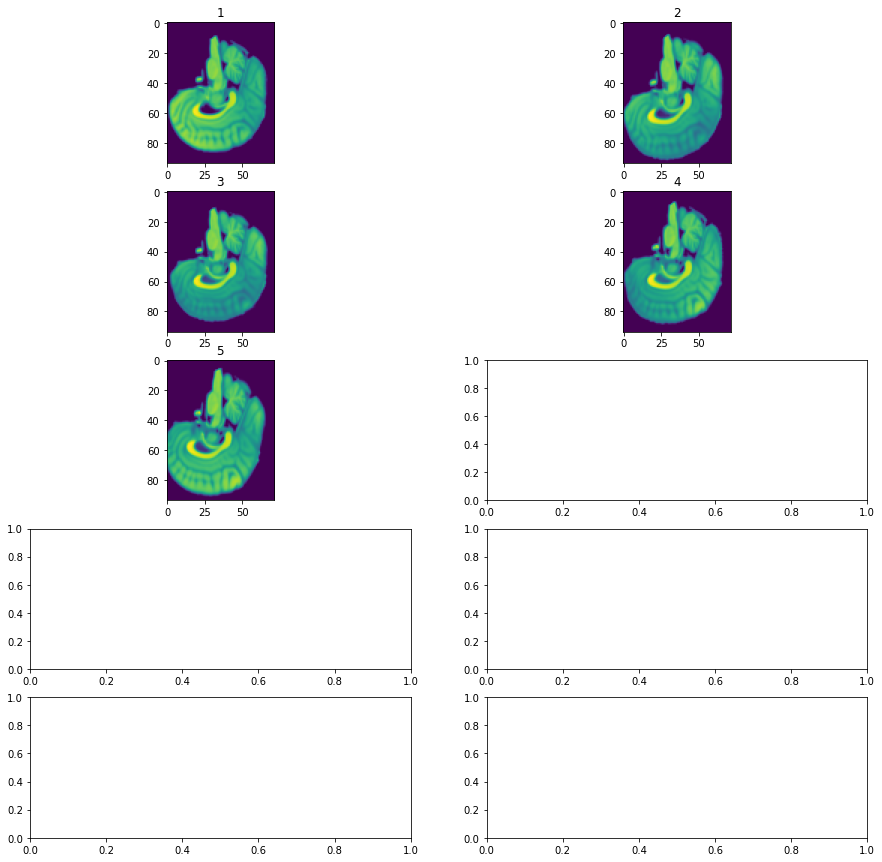

In [7]:
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subjects=notAligned_subjects
    
import nibabel as nib
fig,axs=plt.subplots(5,2,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"
    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"
    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    template_bet=nib.load(TEMPLATE_bet).get_data()
    axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)




# Part2
import nibabel as nib
fig,axs=plt.subplots(5,2,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"
    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"
    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    wanginfunc=nib.load(WANGINFUNC).get_data()
    axs[ii].imshow(wanginfunc[int(wanginfunc.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)




In [37]:
# 查看哪些subject的 batchRegions 成功运行
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd

di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=subs

wang_Yes=[]
wang_Yes_s=''
wang_No=[]

schaefer_Yes=[]
schaefer_Yes_s=''
schaefer_No=[]

for sub in subjects:
    path = f"./wang2014/{sub}/output/roi2_lh.npy"
    if os.path.exists(path):
        wang_Yes.append(sub)
        wang_Yes_s=wang_Yes_s+sub+' '
    else:
        wang_No.append(sub)
        
    path = f"./schaefer2018/{sub}/output/219.npy"
    if os.path.exists(path):
        schaefer_Yes.append(sub)
        schaefer_Yes_s=schaefer_Yes_s+sub+' '
    else:
        schaefer_No.append(sub)
    
print(wang_Yes)
print(len(wang_Yes))

print(schaefer_Yes)
print(len(schaefer_Yes))

print(wang_Yes_s==schaefer_Yes_s)

print(wang_Yes_s)
print(schaefer_Yes_s)

/gpfs/milgram/pi/turk-browne/projects/rtTest
['1206161', '0119173', '1206162', '1130161', '1206163', '0120171', '0111171', '1202161', '0125172', '0110172', '0123173', '0120173', '0110171', '0119172', '0124171', '0123171', '1203161', '0118172', '0118171', '0112171', '1207162', '0117171', '0119174', '0112173', '0112172']
25
['1206161', '0119173', '1206162', '1130161', '1206163', '0120171', '0111171', '1202161', '0125172', '0110172', '0123173', '0120173', '0110171', '0119172', '0124171', '0123171', '1203161', '0118172', '0118171', '0112171', '1207162', '0117171', '0119174', '0112173', '0112172']
25
True
1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172 
1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173

In [32]:
Yes_s_wang=Yes_s

In [34]:
Yes_s_wang==Yes_s

True

In [38]:
len(['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172'])

25

In [42]:
for s in wang_Yes:
    if s not in ['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']:
        print(s)

In [55]:
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
for sub in subjects_correctly_aligned:
#     file = f"wang2014/{sub}/output/uniMaskRank_top1mask.nii.gz"
    file = f"schaefer2018/{sub}/output/uniMaskRank_top1mask.nii.gz"
    if not os.path.exists(file):
        print(sub)

array([176, 111, 136,  61,  41, 231, 195,  21, 284, 167, 157,  75,  55,
       209, 117, 294, 259, 161, 121, 282, 130,  25, 132,  62, 210,  89,
       143, 147,  45,  93,   5, 169, 218,  40,  23,  87, 214,  82,  69,
       190,   3, 127, 286, 262, 251, 232, 150, 145, 237,  63, 156, 125,
       194,  53, 248,  43, 236, 113, 243,  97, 247,  66,  50,  51, 246,
       221, 179, 146, 166, 296, 186, 228, 204,  81,   2, 119, 272, 291,
         7, 108, 289,  12,  48, 219,  76, 242,  94, 100, 281, 118, 128,
       238,  98,   6, 105,  54, 266, 191, 151, 216, 215, 217, 223, 257,
       245, 185,  49, 241, 192, 102, 263, 299,  28,   1, 230, 202,  57,
       250, 140, 201, 244, 255, 187, 233,  10, 297, 264,  59, 184,   4,
         8,  47, 180, 134,  84, 254, 162, 174, 171, 203, 109,  33, 205,
        73,  85, 107, 114, 197, 155,  31, 225, 295, 101, 135, 224, 160,
       277, 103, 239, 116,  11, 288, 260, 249, 207, 188, 198,  34, 276,
        68, 285,  86, 159,  58, 258, 253,  67,  26, 200, 298, 12

In [56]:
len(['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172'])

25

In [57]:
len(subjects_correctly_aligned)

25

(0.219, 0.34)

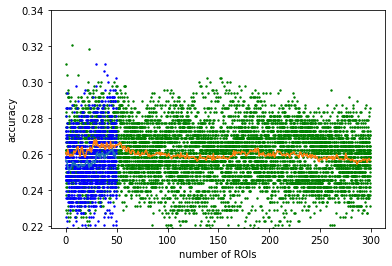

In [1]:
# code to load and compare the result of above:
from glob import glob
import numpy as np
# di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
# subs=glob(f"{di}[0,1]*_neurosketch")
# subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
# subjects=""
# for sub in subs:
#     subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subs=subjects_correctly_aligned
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        # try:
        wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        # except:
        #     pass

schaeferAcc=np.zeros((300,len(subs)))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        # try:
        schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/uniMaskRank_top{num}.npy")
        # print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        # except:
        #     pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
plt.ylim([0.219,0.34])

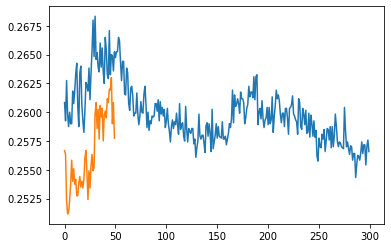

In [63]:
plt.figure()
plt.plot(np.mean(schaeferAcc,axis=1))
plt.plot(np.mean(wangAcc,axis=1))

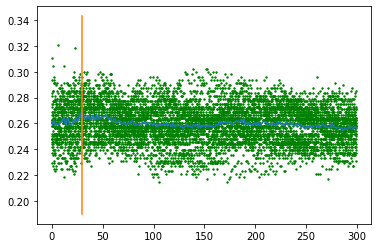

In [71]:
schaeferAcc_mean=np.mean(schaeferAcc,axis=1)
bestID=np.where(schaeferAcc_mean==np.nanmax(schaeferAcc_mean))[0][0]

_=plt.figure()
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.ylim([0.19,0.36])


plt.plot([bestID]*10,np.arange(0.19,0.36,(0.36-0.19)/10))

Text(0.5, 1.0, 'bestID=30')

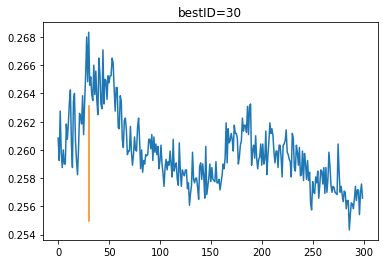

In [78]:
plt.plot(np.arange(schaeferAcc.shape[0]),np.nanmean(schaeferAcc,axis=1))
plt.plot([bestID]*10,np.arange(0.255,0.264,(0.264-0.255)/10))
plt.title(f"bestID={bestID}")

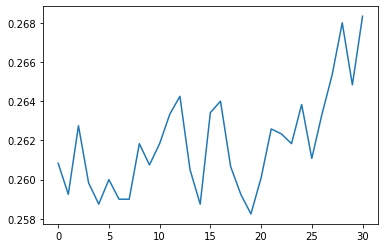

In [81]:
plt.plot(schaeferAcc_mean[:31])

In [87]:
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
len(subjects_correctly_aligned)
for sub in subjects_correctly_aligned:
    print(sub,end=' ')

1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172 

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


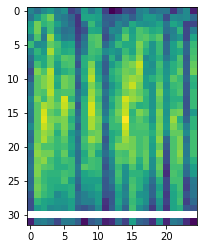

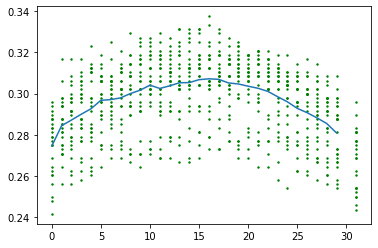

In [26]:
# # plt.savefig('SummaryAccuracy.png')
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=31
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
#     try:
    GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRank_top{}.npy".format(roiloc, subject, N))
#     except:
#         pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T
plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")


bestID=16


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, 'bestID=16')

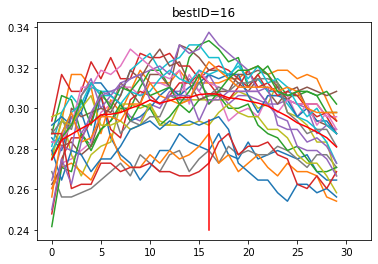

In [47]:
_=plt.figure()
for i in range(GreedyBestAcc.shape[1]):
    plt.plot(GreedyBestAcc[:,i])
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1),c="r")

a=np.nanmean(GreedyBestAcc,axis=1)
bestID=np.where(a==max(a))[0][0]
plt.plot([bestID]*10,np.arange(0.24,0.30,(0.30-0.24)/10),c='r')
print(f"bestID={bestID}")
plt.title(f"bestID={bestID}")

In [40]:
# greedy result 17 ROIs

import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned

bestID
bestROIss=[]
for subject in subjects:
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID+1}")
    # GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
    bestROIs=di['bestROIs']
    bestROIs = [int(bestROI.split(".nii.gz")[0]) for bestROI in bestROIs]
    print(bestROIs)
    bestROIss.append(bestROIs)



bestROIss=np.asarray(bestROIss)

# the brighter means the ROI was used in multiple subjects

# Load the top38 for the subjects_correctly_aligned.
import nibabel as nib
import pandas as pd

bestROIss=bestROIss.reshape(-1)
sub ="1201161"
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
for pn, parc in enumerate(bestROIss):
    _mask = nib.load(workingDir+"/{}/{}/{}.nii.gz".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
#     mask[mask>0] = 1

savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./top{bestID+1}mask.nii.gz")
print("np.unique(mask)=",np.unique(mask))
print(f"fslview_deprecated ./top{bestID+1}mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz")

# fslview_deprecated ./top17mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1201161/neurosketch_recognition_run_1_bet.nii.gz


[275, 213, 272, 16, 164, 17, 23, 223, 262, 20, 37, 221, 65, 171, 61, 176, 159]
[236, 213, 272, 33, 16, 17, 223, 80, 125, 262, 20, 155, 91, 171, 61, 159, 105]
[236, 33, 16, 92, 17, 23, 130, 80, 125, 262, 91, 221, 171, 61, 159, 105, 28]
[236, 213, 33, 16, 92, 164, 223, 80, 125, 155, 91, 171, 61, 159, 105, 28, 78]
[236, 275, 213, 16, 164, 223, 262, 20, 155, 91, 221, 36, 171, 176, 105, 212, 107]
[236, 272, 16, 164, 23, 130, 125, 262, 20, 37, 91, 36, 171, 159, 212, 107, 28]
[275, 272, 33, 16, 92, 17, 223, 80, 125, 91, 36, 65, 159, 105, 107, 28, 78]
[213, 272, 16, 164, 17, 23, 223, 130, 125, 262, 91, 221, 36, 171, 61, 176, 159]
[213, 16, 92, 164, 17, 23, 80, 262, 20, 37, 91, 221, 65, 171, 61, 159, 105]
[213, 272, 33, 92, 17, 23, 223, 80, 262, 20, 221, 36, 65, 61, 212, 107, 78]
[236, 275, 213, 16, 17, 223, 125, 20, 155, 91, 65, 171, 61, 159, 105, 28, 78]
[213, 272, 16, 92, 17, 23, 223, 262, 37, 155, 221, 36, 65, 61, 159, 107, 28]
[213, 272, 33, 23, 223, 125, 20, 37, 155, 65, 171, 61, 176, 159

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:99: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


fslview_deprecated ./top17mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1201161/neurosketch_recognition_run_1_bet.nii.gz


In [21]:
subject = "1206162"
sub=subject
di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{31}")
# GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
bestROIs=di['bestROIs']
bestROIs = [int(bestROI.split(".nii.gz")[0]) for bestROI in bestROIs]
print(bestROIs)
# the brighter means the ROI was used in multiple subjects
import nibabel as nib
import pandas as pd
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
for pn, parc in enumerate(bestROIs):
    _mask = nib.load(workingDir+"/{}/{}/{}.nii.gz".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    # mask[mask>0] = 1
    
savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./top{31}mask.nii.gz")

# fslview_deprecated ./top31mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz
# fslview_deprecated /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/wanginfunc.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz ./top31mask.nii.gz

[236, 275, 213, 272, 33, 16, 92, 164, 17, 23, 223, 130, 80, 125, 262, 20, 37, 155, 91, 221, 36, 65, 171, 61, 176, 159, 105, 212, 107, 28, 78]


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app


In [ ]:
fslview_deprecated /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/wanginfunc.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1206162/neurosketch_recognition_run_1_bet.nii.gz ./top31mask.nii.gz

In [5]:
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import warnings
import numpy as np
import nibabel as nib
import scipy.io as sio
from rtCommon.cfg_loading import mkdir,cfg_loading


toml="/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt/web/conf/sub001_day2_run1.toml"

cfg = cfg_loading(toml)
cfg

toml filename=/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt/web/conf/sub001_day2_run1.toml


{'title': 'rtSynth_rt',
 'session': 2,
 'subjectDay': 2,
 'runNum': [1],
 'scanNum': [1],
 'subjectName': 'sub001',
 'LASTNAME': 'rtSynth_sub001',
 'subjectIDforxnat': 'rtSynth_sub001_ses2',
 'realtimeFolder_subjectName': 'rtSynth_sub001',
 'preDay_YYYYMMDD': 20210114,
 'YYYYMMDD': 20210122,
 'num_total_TRs': 174,
 'TrialNumber': 12,
 'plotTitle': 'Realtime Plot',
 'plotXLabel': 'Sample #',
 'plotYLabel': 'Value',
 'plotXRangeLow': 0,
 'plotXRangeHigh': 20,
 'plotYRangeLow': -1,
 'plotYRangeHigh': 1,
 'plotAutoRangeX': False,
 'plotAutoRangeY': True,
 'dicomNamePattern': '001_{SCAN:06d}_{TR:06d}.dcm',
 'minExpectedDicomSize': 300000,
 'projectDir': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/',
 'tmp_folder': '/gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/',
 'orderFolder': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/orders/',
 'subjects_dir': '/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/',
 'dicom_folder': '/gpfs/m

In [7]:
cfg.dicomNamePattern.format(SCAN=1,TR=2)

'001_000001_000002.dcm'